In [17]:
import pandas as pd
import numpy as np
import cmrl
from emei.core import get_params_str
from pathlib import Path
import matplotlib.pyplot as plt
import yaml

In [34]:
# 递归判断a字典中存在的值是否与b字典相等
def dict_equal(a, b):
    for k, v in a.items():
        if isinstance(v, dict):
            if not dict_equal(v, b[k]):
                return False
        elif v != b[k]:
            return False
    return True


def get_value(d, key):
    if isinstance(key, str):
        if key not in d:
            raise ValueError(f"{key} not in dict")
        return d[key]
    elif isinstance(key, tuple):
        if key[0] not in d:
            raise ValueError(f"{key[0]} not in dict")
        return get_value(d[key[0]], key[1:])
    else:
        raise ValueError("key must be str or tuple")

In [42]:
default_params = dict(freq_rate=1,
                      real_time_scale=0.02,
                      integrator="euler",
                      gravity=9.8,
                      length=0.5,
                      force_mag=10.0)
default_custom_cfg = {}
default_result_key = ["seed"]


def load_log(exp_name="default",
             task_name="ContinuousCartPoleSwingUp-v0",
             params=default_params,
             dataset="SAC-expert-replay",
             custom_cfg=default_custom_cfg,
             log_file="rollout.csv",
             log_key="ep_rew_mean",
             result_key=default_result_key):
    path = Path("./exp") / exp_name / task_name / get_params_str(params) / dataset

    result_dict = {}
    for time_dir in path.glob(r"*"):
        if not time_dir.is_dir() or not (time_dir / ".hydra").exists():
            continue

        config_path = time_dir / ".hydra" / "config.yaml"
        with open(config_path, "r") as f:
            cfg = yaml.load(f, Loader=yaml.FullLoader)

        if not dict_equal(custom_cfg, cfg):
            continue

        log_path = time_dir / "log" / log_file
        if not log_path.exists():
            continue

        key_name = tuple([str(get_value(cfg, k)) for k in result_key])
        df = pd.read_csv(log_path)
        result_dict[key_name] = df[log_key].to_numpy()
    return result_dict

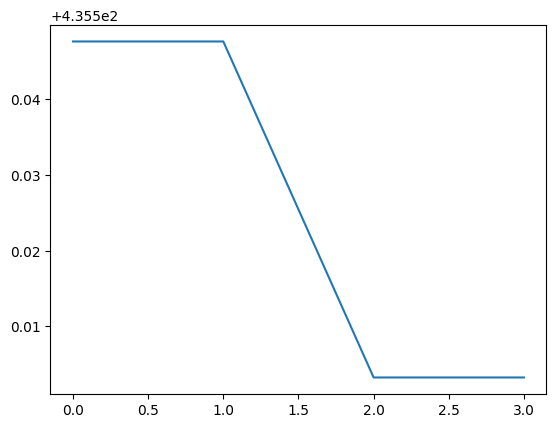

In [54]:
re = load_log(log_file="rollout.csv", log_key="ep_rew_mean")
mean = np.stack(list(re.values())).mean(axis=0)
std = np.stack(list(re.values())).std(axis=0)

plt.plot(mean)
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.5)